### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### CSV to Data Frame

<Axes: xlabel='Date'>

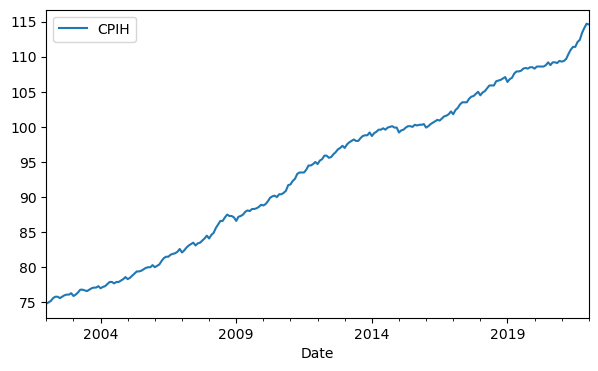

In [2]:
cpih_data = pd.read_csv("cpih_data.csv", index_col=0, parse_dates=True)
cpih_data.plot(figsize=(7, 4))

### ADF Test Functions

In [3]:
# Augmented Dickey-Fuller Test (NO TREND).
def adf_test(timeseries):
    print("NULL HYPOTHESIS: The series has a unit root.")
    print("Results of DF test:")
    dftest = adfuller(
        timeseries,
        maxlag=None,
        regression="c",
        autolag="AIC",
        store=False,
        regresults=False
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used"
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

# Augmented Dickey-Fuller Test + CONTINUOUS TREND (ct).
def adf_test_ct(timeseries):
    print("NULL HYPOTHESIS: The Series has a unit root.")
    print("Results of DF test (+ CT):")
    dftest = adfuller(
        timeseries,
        maxlag=None,
        regression="ct",
        autolag="AIC",
        store=False,
        regresults=False
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used"
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

#### KPSS Test Functions

In [4]:
def kpss_test(timeseries):
    print("NULL HYPOTHESIS: The process is trend stationary.")
    print("Results of KPSS test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

#### Inducing Stationarity: First Difference + Seasonal Adjustments

In [5]:
cpih_diff1 = cpih_data.copy()
cpih_diff1["cpih_diff1"] = cpih_diff1["CPIH"] - cpih_diff1["CPIH"].shift(1)
cpih_diff1 = cpih_diff1.iloc[1:]

NULL HYPOTHESIS: The series has a unit root.
Results of DF test:
Test Statistic                  -4.929363
p-value                          0.000031
Lags Used                       11.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


NULL HYPOTHESIS: The process is trend stationary.
Results of KPSS test:
Test Statistic           0.147673
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/var/folders/qg/1zr492bn2zqcvxkm30bd16tc0000gn/T/ipykernel_15169/3938655962.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


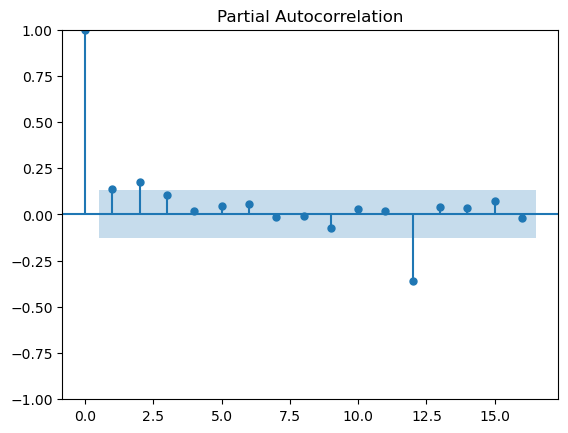

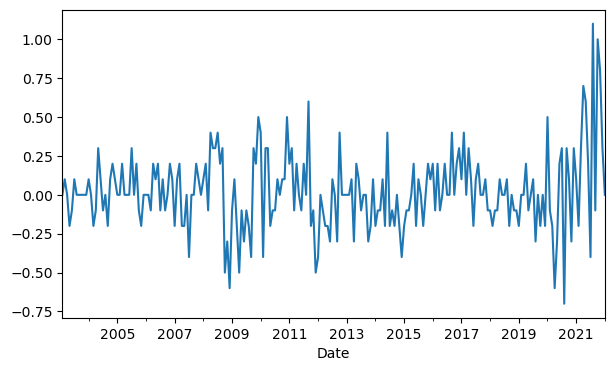

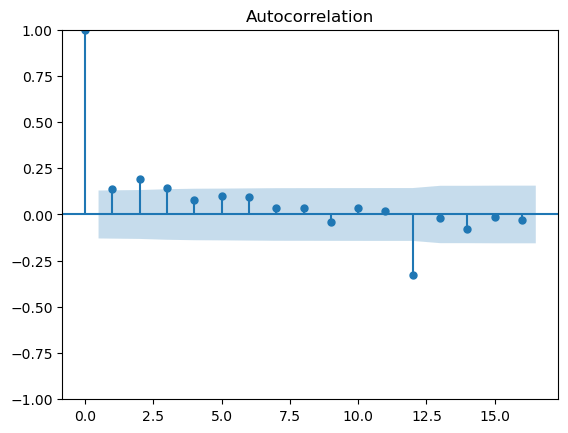

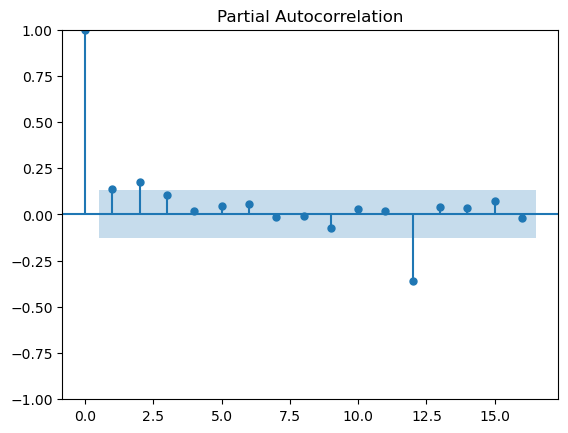

In [6]:
cpih_diff1_SA = cpih_diff1.copy()
cpih_diff1_SA["cpih_diff1_SA"] = cpih_diff1_SA["cpih_diff1"] - cpih_diff1_SA["cpih_diff1"].shift(12) # 12 is the seasonal period.
cpih_diff1_SA = cpih_diff1_SA.iloc[12:]

cpih_diff1_SA_adf_score = adf_test(cpih_diff1_SA["cpih_diff1_SA"])
print("\n")
cpih_diff1_SA_kpss_score = kpss_test(cpih_diff1_SA["cpih_diff1_SA"])

cpih_diff1_SA["cpih_diff1_SA"].plot(figsize=(7, 4))
plot_acf(cpih_diff1_SA["cpih_diff1_SA"].values.squeeze(), lags=16)
plot_pacf(cpih_diff1_SA["cpih_diff1_SA"].values.squeeze(), lags=16)

In [7]:
arima_201_model = sm.tsa.ARIMA(cpih_diff1_SA["cpih_diff1_SA"], order=(2,0,2), trend="n")

# When comparing other models, ARMA(2, 2) was the best fit by AIC and BIC (lowest).

results = arima_201_model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:          cpih_diff1_SA   No. Observations:                  228
Model:                 ARIMA(2, 0, 2)   Log Likelihood                   7.117
Date:                Thu, 04 Jul 2024   AIC                             -4.234
Time:                        14:51:21   BIC                             12.912
Sample:                    02-01-2003   HQIC                             2.684
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7446      0.052     33.829      0.000       1.644       1.846
ar.L2         -0.8675      0.048    -17.904      0.000      -0.962      -0.773
ma.L1         -1.7368      0.043    -40.099      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


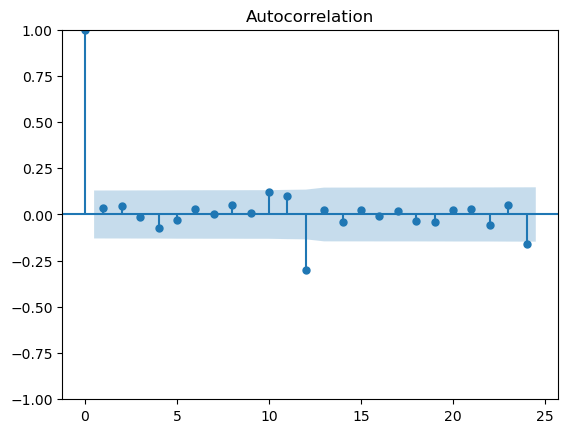

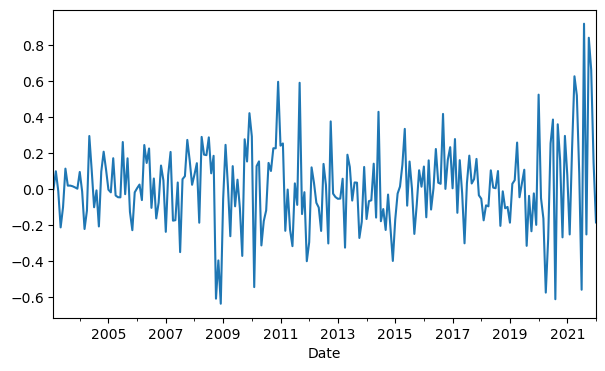

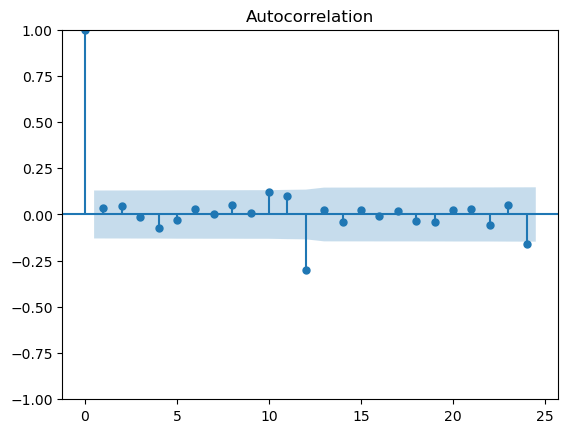

In [8]:
residuals = results.resid

residuals.plot(figsize=(7, 4))
plot_acf(residuals)

In [9]:
# One-step forecast:
print(results.forecast())

2022-02-01    0.197028
Freq: MS, dtype: float64


In [10]:
fcast_res1 =results.get_forecast(steps=12)
# Check this for appropiate number of steps ahead!!
print(fcast_res1.summary_frame())

cpih_diff1_SA      mean   mean_se  mean_ci_lower  mean_ci_upper
2022-02-01     0.197028  0.233988      -0.261580       0.655636
2022-03-01     0.173536  0.233995      -0.285085       0.632158
2022-04-01     0.131834  0.234541      -0.327859       0.591527
2022-05-01     0.079460  0.236016      -0.383122       0.542042
2022-06-01     0.024263  0.238184      -0.442569       0.491096
2022-07-01    -0.026599  0.240473      -0.497917       0.444719
2022-08-01    -0.067452  0.242327      -0.542405       0.407501
2022-09-01    -0.094603  0.243464      -0.571783       0.382577
2022-10-01    -0.106530  0.243927      -0.584619       0.371558
2022-11-01    -0.103787  0.243997      -0.582012       0.374438
2022-12-01    -0.088654  0.244014      -0.566912       0.389604
2023-01-01    -0.064634  0.244220      -0.543296       0.414029


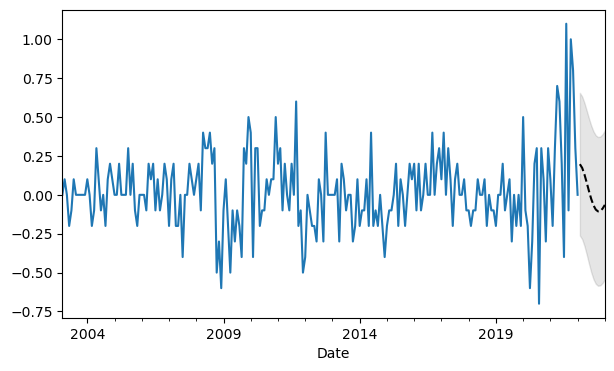

In [11]:
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
cpih_diff1_SA["cpih_diff1_SA"].loc['2003-01-01':].plot(ax=ax)

# Construct the forecasts
fcast = results.get_forecast('2023-01-01').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [12]:
# Cross validation of forecast required?